In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

train_set = MNIST(
    './', 
    download=True,
    transform=transforms.ToTensor(), 
    train=True
)

test_set = MNIST(
    './', 
    download=True,
    transform=transforms.ToTensor(), 
    train=False
)

--2021-10-09 07:30:41--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-10-09 07:30:41--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [       <=>          ]  33.20M  25.7MB/s    in 1.3s    

2021-10-09 07:30:42 (25.7 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=128, shuffle=False)

In [12]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1, 48, kernel_size=3), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(48, 96, kernel_size=3), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=1, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 10, kernel_size=1), 
        nn.AvgPool2d(kernel_size=8),
    )
  def forward(self, x):
    logits = self.net(x)
    return logits.view(-1, 10)

In [13]:
# Pretrain classifier
classifier = Classifier().cuda()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
for epoch in range(20):
  for i, (x,y) in enumerate(train_loader):
    x, y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    train_loss = loss(classifier(x), y)
    train_loss.backward()
    optimizer.step()
    if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Classifier_loss: {}'.format(epoch+1, 20, i+1, len(train_loader), train_loss.item()))

Epoch [1/20], Step [1/469], Classifier_loss: 2.3045690059661865
Epoch [1/20], Step [101/469], Classifier_loss: 0.7583668231964111
Epoch [1/20], Step [201/469], Classifier_loss: 0.392402708530426
Epoch [1/20], Step [301/469], Classifier_loss: 0.20682597160339355
Epoch [1/20], Step [401/469], Classifier_loss: 0.19816024601459503
Epoch [2/20], Step [1/469], Classifier_loss: 0.18145281076431274
Epoch [2/20], Step [101/469], Classifier_loss: 0.1319606453180313
Epoch [2/20], Step [201/469], Classifier_loss: 0.17492762207984924
Epoch [2/20], Step [301/469], Classifier_loss: 0.13758894801139832
Epoch [2/20], Step [401/469], Classifier_loss: 0.11321841925382614
Epoch [3/20], Step [1/469], Classifier_loss: 0.10539592057466507
Epoch [3/20], Step [101/469], Classifier_loss: 0.11800473183393478
Epoch [3/20], Step [201/469], Classifier_loss: 0.1449347287416458
Epoch [3/20], Step [301/469], Classifier_loss: 0.04362476244568825
Epoch [3/20], Step [401/469], Classifier_loss: 0.07333600521087646
Epoch [

In [14]:
torch.save(classifier.state_dict(), 'pretrained_classifier.pth')

In [100]:
def accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy: %s %%' % (100 * correct / total))

In [36]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    layers = [
              nn.Conv2d(1, 64, 5, padding=2, stride=2), nn.BatchNorm2d(64, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(64, 128, 5, padding=2, stride=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(128, 256, 5, padding=2, stride=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Flatten(), nn.Linear(256*4*4, 2048), nn.BatchNorm1d(2048, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Linear(2048, 16),
    ]
    self.net = nn.Sequential(*layers)

  def forward(self,x):
    return self.net(x)

In [66]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
              nn.Linear(16, 256*4*4), nn.BatchNorm1d(256*4*4, momentum=0.9), nn.LeakyReLU(0.2),
              )
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(256,256,6, stride=2, padding=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(256,128,6, stride=2, padding=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128,32,6, stride=2, padding=3), nn.BatchNorm2d(32, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(32,1,5, stride=1, padding=3), nn.Tanh()
    )

  def forward(self, x):
    x = self.linear(x)
    x = x.view(-1, 256, 4, 4)
    return self.conv(x)

In [109]:
class Generator(nn.Module):
  def __init__(self, epsilon):
    super().__init__()
    self.decoder = Decoder()
    self.encoder = Encoder()
    self.classifier = classifier
    self.epsilon = epsilon
    for param in classifier.parameters():
      param.requires_grad = False

  def loss(self, x, y):
    z = self.encoder(x)
    perturbation = epsilon * self.decoder(z)
    predictions = F.softmax(self.classifier(x+perturbation),1)
    return predictions.gather(1, y.view(-1,1)).mean(), perturbation

In [ ]:
epsilon = 0.1
epochs = 5
model = Generator(epsilon).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(epochs):
  for i, (x,y) in enumerate(train_loader):
    x,y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    loss, perturbation = model.loss(x,y)
    loss.backward()
    optimizer.step()
    if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Loss: {}'.format(epoch+1, epochs, i+1, len(train_loader), loss.item()))

Epoch [1/5], Step [1/469], Loss: 0.9934682250022888
Epoch [1/5], Step [101/469], Loss: 0.5766056776046753
Epoch [1/5], Step [201/469], Loss: 0.5480083227157593
Epoch [1/5], Step [301/469], Loss: 0.47168421745300293
Epoch [1/5], Step [401/469], Loss: 0.4709986746311188
Epoch [2/5], Step [1/469], Loss: 0.4014093279838562
Epoch [2/5], Step [101/469], Loss: 0.36564743518829346
Epoch [2/5], Step [201/469], Loss: 0.41835901141166687


In [111]:
def adv_accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          outputs = net(model.loss(images, labels)[1] + images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Adversarial accuracy: %s %%' % (100 * correct / total))

In [112]:
adv_accuracy(classifier)

Adversarial accuracy: 0.51 %


In [ ]:
baseClassifier = BaseClassifier().cuda()
def train_base(device, train_loader):
  classifier_optimizer = torch.optim.Adam(baseClassifier.parameters(), lr=1e-3)
  loss = nn.CrossEntropyLoss()
  for epoch in range(epochs):
    for i, (x,y) in enumerate(train_loader):
      x, y = x.to(device), y.to(device)
      classifier_optimizer.zero_grad()
      classifier_loss = loss(baseClassifier(x), y) 
      classifier_loss.backward()
      classifier_optimizer.step()      
      if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Classifier_loss: {}'.format(epoch+1, epochs, i+1, len(train_loader), classifier_loss))


In [ ]:
train_base(device, train_loader)

Epoch [1/10], Step [1/469], Classifier_loss: 2.3021018505096436
Epoch [1/10], Step [101/469], Classifier_loss: 2.016310214996338
Epoch [1/10], Step [201/469], Classifier_loss: 2.084836959838867
Epoch [1/10], Step [301/469], Classifier_loss: 1.9202932119369507
Epoch [1/10], Step [401/469], Classifier_loss: 1.9438130855560303
Epoch [2/10], Step [1/469], Classifier_loss: 2.002037286758423
Epoch [2/10], Step [101/469], Classifier_loss: 1.9903645515441895
Epoch [2/10], Step [201/469], Classifier_loss: 1.9259456396102905
Epoch [2/10], Step [301/469], Classifier_loss: 1.836113452911377
Epoch [2/10], Step [401/469], Classifier_loss: 1.8242815732955933
Epoch [3/10], Step [1/469], Classifier_loss: 1.850592851638794
Epoch [3/10], Step [101/469], Classifier_loss: 1.8252578973770142
Epoch [3/10], Step [201/469], Classifier_loss: 1.8615632057189941
Epoch [3/10], Step [301/469], Classifier_loss: 1.8342620134353638
Epoch [3/10], Step [401/469], Classifier_loss: 1.7241915464401245
Epoch [4/10], Step [1

In [ ]:
base_classifier_loss  = 0
adv_classifier_loss = 0 
loss = nn.CrossEntropyLoss()
for x,y in test_loader:
  x,y = x.to(device), y.to(device)
  perturbation = generator(x)
  perturbed_image = x + perturbation
  base_classifier_loss += loss(baseClassifier(x), y)
  adv_classifier_loss += loss(classifier(x), y)

In [ ]:
print("Adversarial classifier loss: ", adv_classifier_loss.detach().cpu().numpy(), "||| Base classifier loss: ", base_classifier_loss.detach().cpu().numpy())

Adversarial classifier loss:  117.13299 ||| Base classifier loss:  124.39505


Now, let's take random samples from the test set and inspect their behavior under adversarial perturbations. 

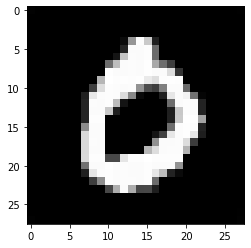

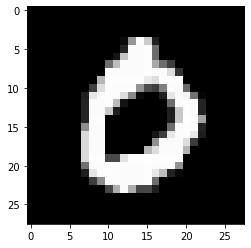

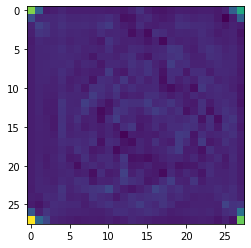

0.016742798
torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000, 0.9995, 1.0000, 1.0000, 1.0000, 0.9727, 0.9996,
        1.0000, 0.5967, 1.0000, 1.0000, 0.6286, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9925, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9987, 0.9999,
        1.0000, 0.9890, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 0.9996, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9795, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997, 0.9219,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997, 1.0000, 0.6922,
        1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 0.9999, 0.9999, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9065, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.999

In [ ]:
#To see the adversarial examples, choose the index from [3, 10, 13, 18]
i = 3
for x, y in test_loader:
  x,y = x.to(device), y.to(device)
  perturbation = generator(x)
  perturbed_image = x + perturbation
  base_pred = baseClassifier(perturbed_image)
  adv_pred = classifier(perturbed_image)

  image = (perturbed_image).detach().cpu().numpy()
  original = x[i][0].cpu().numpy()
  plt.imshow(image[i][0], cmap='gray')
  plt.show()
  plt.imshow(original, cmap='gray')
  plt.show()
  plt.imshow((image-original)[i][0]) #perturbation visualization
  plt.show()
  print(np.linalg.norm((image-original)[i][0], ord=2))
  print(torch.max(base_pred.data,1))
  print(torch.max(adv_pred.data,1))
  print(y)
  break


  i+=1


In [ ]:
total = 0
base_correct = 0
adv_correct = 0
for x, y in test_loader:
  x, y = x.to(device), y.to(device)
  perturbation = generator(x)
  perturbed_image = x + perturbation

  base_out = baseClassifier(perturbed_image)
  adv_out = classifier(perturbed_image)
  _, base_pred = torch.max(base_out.data, 1)
  _, adv_pred = torch.max(adv_out.data, 1)
  total += y.size(0)
  adv_correct += (adv_pred == y).sum().item()
  base_correct += (base_pred == y).sum().item()

print("Adversarially trained network's accuracy:", adv_correct/total, "Base network's accuracy:", base_correct/total)

Adversarially trained network's accuracy: 0.9782 Base network's accuracy: 0.8843
